In [1]:
import os
import glob
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.preprocessing import image

from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions


In [2]:
train_data_path = os.path.join('..', 'Dataset', 'data', 'train') # '/content/data/train'
valid_data_path = os.path.join('..', 'Dataset', 'data', 'test') # '/content/data/test'

train_data_agumentation = ImageDataGenerator(rescale = 1./255
                                            #  shear_range = 0.2,
                                            #  zoom_range = 0.2,
                                            #  horizontal_flip = True,
                                            #  vertical_flip = True
                                             )

val_data_agumentation = ImageDataGenerator(rescale = 1./255)


# load training data
train_data = train_data_agumentation.flow_from_directory(directory = train_data_path,
                                                         target_size = (224,224),
                                                         class_mode = 'categorical',
                                                         batch_size = 64)

val_data = val_data_agumentation.flow_from_directory(directory = valid_data_path,
                                                     target_size = (224,224),
                                                     class_mode = 'categorical',
                                                     batch_size = 64)

Found 3216 images belonging to 3 classes.
Found 1584 images belonging to 3 classes.


In [3]:
checkpoint_dir = 'checkpoints_vgg16'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint_filepath = os.path.join(checkpoint_dir,
                                   "model_epoch_{epoch:02d}_val_acc_{val_accuracy:.2f}_val_loss_{val_loss:.2f}.keras")

checkpoint = ModelCheckpoint(filepath = checkpoint_filepath,
                             monitor = 'val_loss',
                             verbose = 0,
                             save_best_only = True,
                             save_weights_only = False,
                             mode = 'auto')

early = EarlyStopping(monitor = 'val_loss',
                      min_delta = 0,
                      patience = 10,
                      verbose = 0,
                      mode = 'auto')

reduceLR = ReduceLROnPlateau(monitor="val_loss", 
                             factor=0.1,
                             patience=10, 
                             verbose=0, 
                             mode="auto",
                             min_delta=0.0001, 
                             cooldown=0,
                             min_lr=0.0)

csv_logger = CSVLogger('training.log')

callbacks_list = [checkpoint, reduceLR, csv_logger] #, early


In [4]:
image_size = [224, 224]
num_classes = len(glob.glob(train_data_path+'/*'))

# Load the pre-trained model
model = VGG16(input_shape = image_size + [3],
              weights = 'imagenet',
              include_top = False)

# our layers - you can add more if you want
x = Flatten()(model.output)

output_layer = Dense(num_classes, activation='softmax')(x)

# model.layers.trainable = False
for layer in model.layers:
    layer.trainable = False

# create a model object
model = Model(inputs = model.input, outputs = output_layer)
model.summary()




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [5]:
#Initializing the hyperparameters
sgd = SGD(learning_rate = 0.01, 
          momentum = 0.9, 
          nesterov = False)

adam = Adam(learning_rate = 0.001, 
            beta_1 = 0.9,
            beta_2 = 0.999,
            epsilon = 1e-07)

# compile the model with adam optimizer, categorical_croosentropy loss function
# model.compile(optimizer = 'adam',
#               loss = 'categorical_crossentropy',
#               metrics = ['accuracy'])

model.compile(optimizer = sgd,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

# model.compile(optimizer = adam
#               loss = 'categorical_crossentropy',
#               metrics = ['accuracy'])


In [17]:
history = model.fit(train_data,
                    batch_size = 32,
                    epochs = 5,
                    validation_data = val_data,
                    callbacks = callbacks_list)

# steps_per_epoch=len(training_set),
# validation_steps=len(test_set),

model.save('VGG16_SGD_model_last_epoch.karas')

Epoch 1/5
51/51 [==============================] - 1123s 22s/step - loss: 5.9576 - accuracy: 0.5572 - val_loss: 6.6059 - val_accuracy: 0.5385 - lr: 0.0100
Epoch 2/5
51/51 [==============================] - 1109s 22s/step - loss: 16.1434 - accuracy: 0.4835 - val_loss: 5.5731 - val_accuracy: 0.5707 - lr: 0.0100
Epoch 3/5
51/51 [==============================] - 1111s 22s/step - loss: 5.2849 - accuracy: 0.5979 - val_loss: 28.0336 - val_accuracy: 0.3390 - lr: 0.0100
Epoch 4/5
51/51 [==============================] - 1060s 21s/step - loss: 7.1758 - accuracy: 0.5725 - val_loss: 4.1126 - val_accuracy: 0.5833 - lr: 0.0100
Epoch 5/5
51/51 [==============================] - 1067s 21s/step - loss: 10.3017 - accuracy: 0.5090 - val_loss: 29.0489 - val_accuracy: 0.3359 - lr: 0.0100


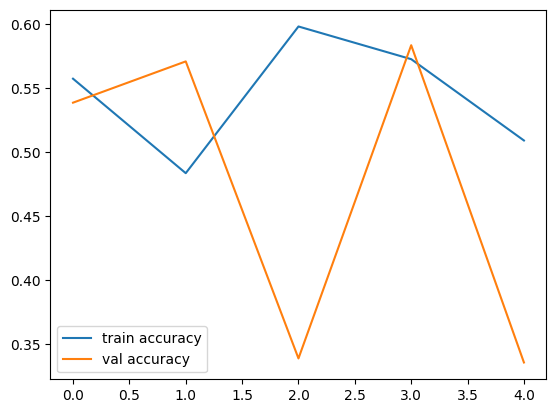

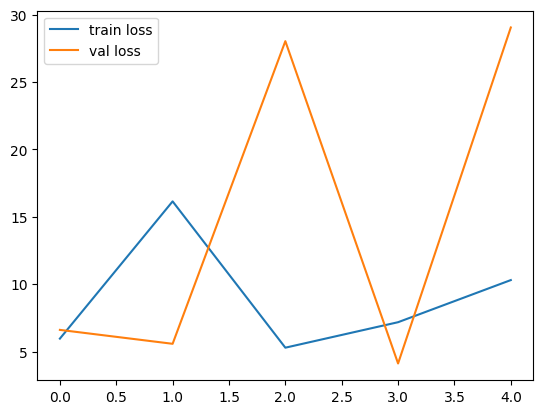

In [19]:
# accuracies
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.savefig('accuracy_and_val_accuracy.png', dpi=200)
plt.show()
 
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('loss_and_val_loss.png', dpi=200)
plt.show()


In [ ]:
score = model.evaluate(train_data, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

In [ ]:
score = model.evaluate(val_data, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [7]:
model.compile(optimizer = adam,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

history_adam = model.fit(train_data, 
                         batch_size = 32, 
                         epochs = 5, 
                         validation_data = val_data, 
                         callbacks = callbacks_list)



Epoch 1/5


51/51 [==============================] - 1073s 21s/step - loss: 1.0444 - accuracy: 0.5215 - val_loss: 0.7977 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 2/5
51/51 [==============================] - 1068s 21s/step - loss: 0.7247 - accuracy: 0.6791 - val_loss: 0.7290 - val_accuracy: 0.6799 - lr: 0.0010
Epoch 3/5
51/51 [==============================] - 1068s 21s/step - loss: 0.5960 - accuracy: 0.7544 - val_loss: 0.7264 - val_accuracy: 0.6534 - lr: 0.0010
Epoch 4/5
51/51 [==============================] - 1057s 21s/step - loss: 0.5046 - accuracy: 0.8156 - val_loss: 0.6638 - val_accuracy: 0.7039 - lr: 0.0010
Epoch 5/5
51/51 [==============================] - 1095s 22s/step - loss: 0.4458 - accuracy: 0.8461 - val_loss: 0.6913 - val_accuracy: 0.6843 - lr: 0.0010


In [8]:
model.save('VGG16_adam_model_last_epoch.karas')

INFO:tensorflow:Assets written to: VGG16_adam_model_last_epoch.karas\assets


INFO:tensorflow:Assets written to: VGG16_adam_model_last_epoch.karas\assets


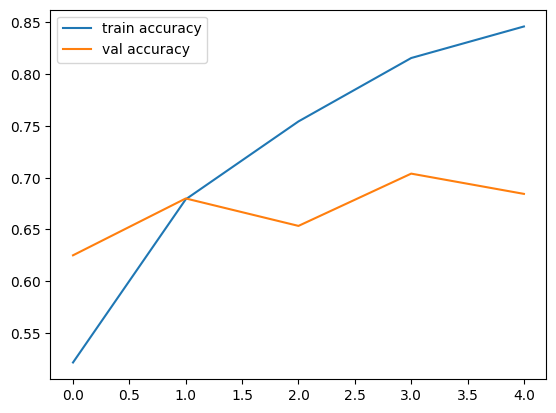

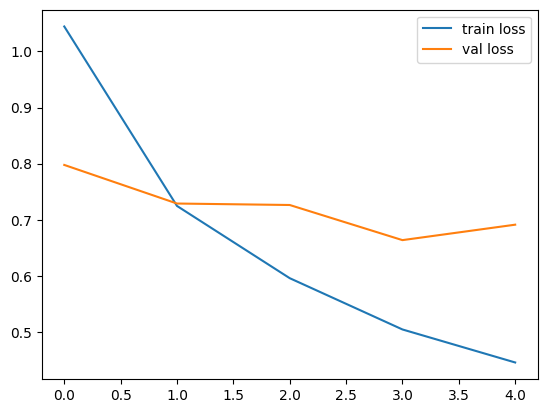

In [9]:
# accuracies
plt.plot(history_adam.history['accuracy'], label='train accuracy')
plt.plot(history_adam.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.savefig('accuracy_and_val_accuracy.png', dpi=200)
plt.show()
 
# loss
plt.plot(history_adam.history['loss'], label='train loss')
plt.plot(history_adam.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('loss_and_val_loss.png', dpi=200)
plt.show()


In [ ]:
score = model.evaluate(train_data, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

In [ ]:
score = model.evaluate(val_data, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])